In [ ]:
pip install tensorflow

### 동일인물 구별 실험을 위한 사진쌍 데이터 생성
#### 약 400장의 사진 중 랜덤한 두 사진을 선택하여 사진쌍을 생성
#### 생성할 때 선택된 사진쌍이 동일인물인 경우 200쌍과 동일인물이 아닐 경우 200쌍, 총 400쌍의 사진쌍을 생성

In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. 데이터 로드
def load_dataset(data_path):
    dataset = []
    labels = []
    for person_id, person_dir in enumerate(os.listdir(data_path)):
        person_path = os.path.join(data_path, person_dir)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                dataset.append(img_path)
                labels.append(person_id)
    return dataset, labels

# 2. 쌍 생성 함수
def create_image_pairs(dataset, labels, num_pairs_same, num_pairs_diff):
    same_pairs = []
    diff_pairs = []
    label_to_indices = {}

    # 라벨 별 인덱스 그룹화
    for idx, label in enumerate(labels):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)

    # 동일 인물 쌍 생성
    for _ in range(num_pairs_same):
        label = random.choice(list(label_to_indices.keys()))
        idx1, idx2 = random.sample(label_to_indices[label], 2)
        same_pairs.append((dataset[idx1], dataset[idx2], 1))  # Label: 1 (Same)

    # 다른 인물 쌍 생성
    unique_labels = list(label_to_indices.keys())
    for _ in range(num_pairs_diff):
        label1, label2 = random.sample(unique_labels, 2)
        idx1 = random.choice(label_to_indices[label1])
        idx2 = random.choice(label_to_indices[label2])
        diff_pairs.append((dataset[idx1], dataset[idx2], 0))  # Label: 0 (Different)

    return same_pairs + diff_pairs

# 3. 데이터셋 생성
def prepare_image_pairs(data_path, num_pairs_same=200, num_pairs_diff=200):
    dataset, labels = load_dataset(data_path)
    pairs = create_image_pairs(dataset, labels, num_pairs_same, num_pairs_diff)
    random.shuffle(pairs)
    return pairs


# 4. TF 데이터셋 변환
def create_tf_dataset(pairs, image_size=(112, 112)):  # ArcFace에 맞게 (112, 112)로 설정
    def preprocess(img1_path, img2_path, label):
        # 이미지 로드 및 전처리
        img1 = tf.image.resize(
            tf.image.decode_jpeg(tf.io.read_file(img1_path), channels=3),
            image_size
        ) / 255.0
        img2 = tf.image.resize(
            tf.image.decode_jpeg(tf.io.read_file(img2_path), channels=3),
            image_size
        ) / 255.0

        # label을 float32로 변환
        label = tf.cast(label, tf.float32)
        return (img1, img2), label

    # Dataset 생성
    img1_paths = [pair[0] for pair in pairs]
    img2_paths = [pair[1] for pair in pairs]
    labels = [pair[2] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img1_paths, img2_paths, labels))
    dataset = dataset.map(
        lambda img1_path, img2_path, label: tf.py_function(
            preprocess, [img1_path, img2_path, label],
            (tf.float32, tf.float32)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset



In [ ]:
# 사용 예제
data_path = '/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/cropped_faces'  # 데이터 디렉토리 경로
pairs = prepare_image_pairs(data_path)

# ArcFace 모델용 112x112 크기의 TensorFlow 데이터셋 생성
tf_dataset = create_tf_dataset(pairs, image_size=(112, 112))

# TF 데이터셋 확인
for (img1, img2), label in tf_dataset.take(1):
    print(img1.shape, img2.shape, label)

(112, 112, 3) (112, 112, 3) tf.Tensor(1.0, shape=(), dtype=float32)


### 데이터셋 pkl파일로 저장해놓기

In [ ]:
import pickle

# 직렬화하여 .pkl 파일로 저장
file_path = '/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/image_pairs.pkl'

with open(file_path, 'wb') as f:
    pickle.dump(pairs, f)

print("Pairs have been saved to 'image_pairs.pkl'.")


Pairs have been saved to 'image_pairs.pkl'.


잘 됐는지 pkl파일 불러와보기

In [ ]:
# 저장된 .pkl 파일 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/DAT 4th/팀프로젝트/image_pairs.pkl', 'rb') as f:
    loaded_pairs = pickle.load(f)

print(f"Loaded {len(loaded_pairs)} pairs.")

Loaded 400 pairs.


### 이미지 쌍 잘 생성되었는지 확인

In [ ]:
import numpy as np

# 생성된 이미지 쌍의 라벨 통계 확인
def check_pair_statistics(pairs):
    # 라벨을 추출하여 동일인물(1)과 다른인물(0) 비율 계산
    labels = [pair[2] for pair in pairs]
    unique, counts = np.unique(labels, return_counts=True)

    # 동일인물(1)과 다른인물(0)의 개수 출력
    label_counts = dict(zip(unique, counts))
    print(f"Same person pairs (label 1): {label_counts.get(1, 0)}")
    print(f"Different person pairs (label 0): {label_counts.get(0, 0)}")
    print(f"Total pairs: {len(pairs)}")


In [ ]:
# 이미지 쌍의 라벨 통계 확인
check_pair_statistics(pairs)

Same person pairs (label 1): 200
Different person pairs (label 0): 200
Total pairs: 400


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# 샘플 쌍 확인 함수
def visualize_image_pairs(tf_dataset, num_samples=5):
    """이미지 쌍 시각화"""
    for (img1, img2), label in tf_dataset.take(num_samples):
        img1 = img1.numpy()
        img2 = img2.numpy()
        label = label.numpy()

        # 이미지 시각화
        plt.figure(figsize=(6, 3))

        # 첫 번째 이미지
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.axis("off")
        plt.title("Image 1")

        # 두 번째 이미지
        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.axis("off")
        plt.title("Image 2")

        # 라벨 출력
        plt.suptitle(f"Label: {'Same' if label == 1 else 'Different'}")
        plt.show()



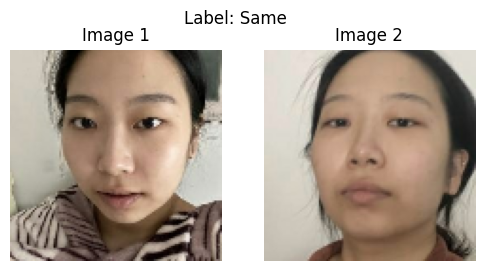

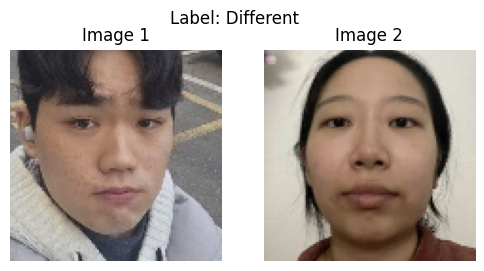

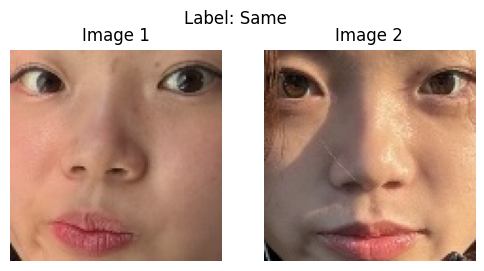

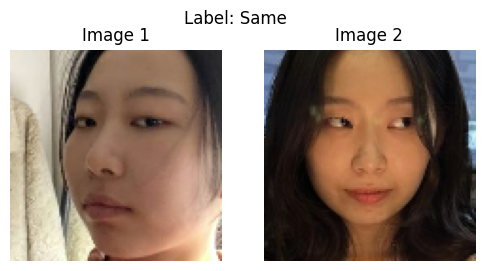

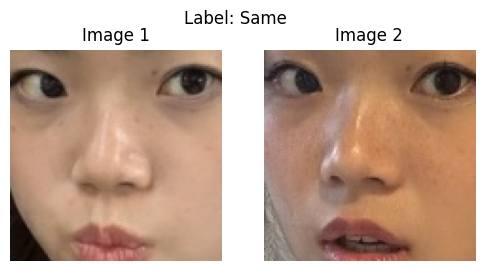

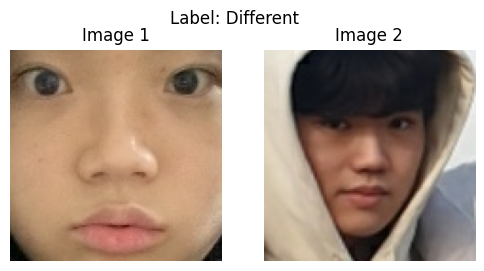

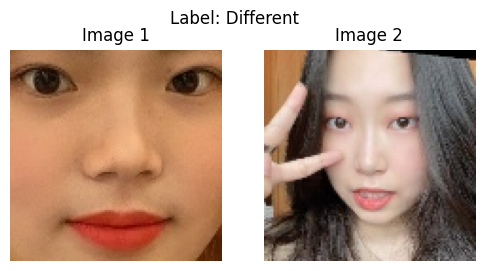

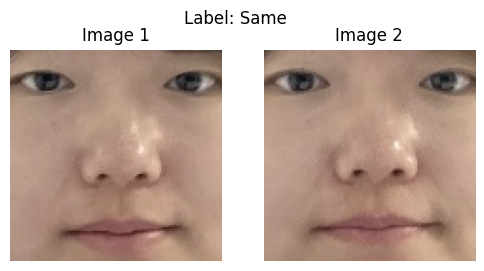

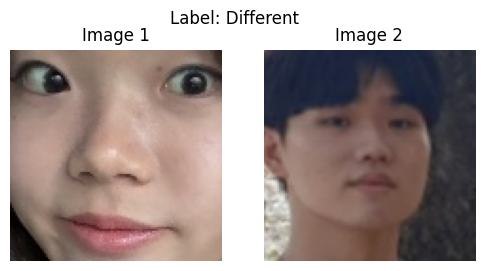

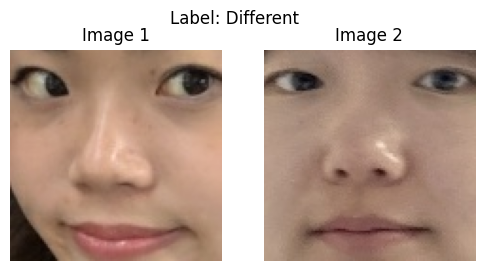

In [ ]:
# 시각화 실행
visualize_image_pairs(tf_dataset, num_samples=10)